In [34]:
#Import Library
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import requests
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

In [2]:
#global variable
NUM_WORDS = 1000
OOV_TOKEN = "<OOV>"
PADDING = 'post'
MAXLEN = 120
EMBEDDING_DIM = 16

In [3]:
#Retrieve DS from Github
dataset_link = 'https://raw.githubusercontent.com/Willie29/capstone-C23-PS056/main/ML/Dataset_Combined.csv'
response = requests.get(dataset_link)

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/Willie29/capstone-C23-PS056/main/ML/Dataset_Combined.csv')
# Identify Unnamed columns
unnamed_columns = [col for col in data.columns if 'Unnamed' in col]

# Drop Unnamed columns
data = data.drop(unnamed_columns, axis=1)
#shuffle data
data = data.sample(frac=1)

print(data.head())
print("\n")
print(data.tail())

       Label                                              Tweet
1177  Non_HS                            hai kamu safe flight ya
1625  Non_HS  Indera penciuman mereka sangat tajam dan sensi...
2302      HS                  KOK GUE LIAT INI SIH KAMPRET WKWK
1007  Non_HS                          selesai nonton dilan bang
2545      HS  Cuba la tgk anime ni, Karakai Jozu No Takagi-s...


       Label                                              Tweet
771   Non_HS                                    aku suka tobeli
1520  Non_HS  Anjing tersebut memberikan ciuman pada pemilik...
1155  Non_HS       aku wes katam yang kyk gitu disini wkwkkwkww
2106      HS  presiden malu bangsa plonga plongo tulah toleh...
1428  Non_HS                       Monyet sama panda lucu mana?


In [5]:
data['Label'].value_counts()

Label
HS        1722
Non_HS    1639
Name: count, dtype: int64

In [6]:
def parse_data(data):
    labels = []
    tweets = []
    
    for _, row in data.iterrows():
        cond = (0 if row['Label'] == "HS" else 1)
        labels.append(cond)
        tweets.append(row['Tweet'])
            
    return labels, tweets

# Assuming 'data' is your DataFrame
labels, tweets = parse_data(data)

In [7]:
print(f"Example number in dataset is {len(tweets)} examples\n")

print(f"2nd example:\n{tweets[1]}\n")
print(f"Last example:\n{tweets[-1]}")

Example number in dataset is 3361 examples

2nd example:
Indera penciuman mereka sangat tajam dan sensitif.

Last example:
Monyet sama panda lucu mana?


In [8]:
#90-10 ratio train-test
def train_test_split(labels,tweets):
    train_size = int(len(tweets) * 0.9)

    train_labels = labels[:train_size]
    train_tweets = tweets[:train_size]

    test_labels = labels[train_size:]
    test_tweets = tweets[train_size:]
    
    return train_labels, train_tweets, test_labels, test_tweets

In [9]:
train_labels, train_tweets, test_labels, test_tweets = train_test_split(labels, tweets)

print(f" {len(train_labels)} sentences for training.")
print(f" {len(train_tweets)} labels for training.")
print(f" {len(test_labels)} sentences for validation.")
print(f" {len(test_tweets)} labels for validation.")

 3024 sentences for training.
 3024 labels for training.
 337 sentences for validation.
 337 labels for validation.


In [10]:
print(train_tweets[:3])
print(train_labels[:3])
print(test_tweets[:3])
print(test_labels[:3])

['hai kamu safe flight ya', 'Indera penciuman mereka sangat tajam dan sensitif.', 'KOK GUE LIAT INI SIH KAMPRET WKWK']
[1, 1, 0]
['mfs folowan rt ja ntar aku folow follback tpi', 'bersusah susah dahulu bersenang senang kemudian kau kaya dulu aku kaya kemudian', 'aku nk walk in ajelah senang']
[1, 1, 1]


In [11]:
#tokenizer function
def fit_tokenizer(train_sentences, num_words, oov_token):
    tokenizer = Tokenizer(num_words = num_words, oov_token = oov_token)
    tokenizer.fit_on_texts(train_sentences)
    return tokenizer

In [12]:
#buat test doang
def lowercase(list_sentence):
    lower_sentence = list_sentence
    for i in range(len(list_sentence)):
        lower_sentence[i] = lower_sentence[i].lower()
    return lower_sentence

In [13]:
#tokenize sentence
#test_tweets1 = test_tweets[0].lower()
#test_tweets1 = test_tweets1.lower()
lower_train_tweets = lowercase(train_tweets)
tokenizer = fit_tokenizer(lower_train_tweets, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index
print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 8375 words

<OOV> token included in vocabulary


In [14]:
#seq and padding function
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, maxlen = maxlen, padding = padding)
    return padded_sequences

In [15]:
#seq and padding sentence
lower_val_tweets = lowercase(test_tweets)
train_padded_seq = seq_and_pad(lower_train_tweets, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(lower_val_tweets, tokenizer, PADDING, MAXLEN)
print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (3024, 120)

Padded validation sequences have shape: (337, 120)


In [16]:
#Model Structure
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length = MAXLEN),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(units = 32, activation= 'relu'),
    tf.keras.layers.Dense(units = 2, activation='softmax')
])

In [17]:
print(type(test_labels))

<class 'list'>


In [18]:
test_labels_changed = np.array(test_labels)
print(type(test_labels_changed))
print(type(train_padded_seq))
print(type(val_padded_seq))
print(type(train_labels))
print("\n")
print(train_padded_seq)
print("\n")
print(val_padded_seq)
print(test_labels_changed[:10])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>


[[498   6   1 ...   0   0   0]
 [  1   1  41 ...   0   0   0]
 [ 75  42 173 ...   0   0   0]
 ...
 [  4  76  47 ...   0   0   0]
 [498  12  12 ...   0   0   0]
 [164 301   1 ...   0   0   0]]


[[  1   1 597 ...   0   0   0]
 [  1 336   1 ...   0   0   0]
 [  2 777   1 ...   0   0   0]
 ...
 [  2   1   1 ...   0   0   0]
 [149 182 445 ...   0   0   0]
 [ 39  18   1 ...   0   0   0]]
[1 1 1 0 1 1 1 1 1 0]


In [19]:
train_labels_changed = np.array(train_labels)
print(train_labels_changed)

[1 1 0 ... 0 1 0]


In [20]:
# Menggunakan LabelEncoder untuk mengubah label menjadi bilangan bulat
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels_changed)
test_labels_encoded = label_encoder.transform(test_labels_changed)

# Mengubah label menjadi one-hot encoded
num_classes = len(label_encoder.classes_)
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels_encoded, num_classes=num_classes)
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels_encoded, num_classes=num_classes)

In [21]:
print(train_labels_encoded)
print("\n")
print(test_labels_encoded)
print("\n")
print(train_labels_one_hot)
print("\n")
print(test_labels_one_hot)

[1 1 0 ... 0 1 0]


[1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 0
 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 0
 0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1
 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 0 1 0 1 0
 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1
 1 0 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0
 1 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 1
 1 1 0 1]


[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1

In [29]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam() ,metrics=['accuracy'])

history_1 = model.fit(train_padded_seq, train_labels_one_hot, epochs=30, validation_data=(val_padded_seq, test_labels_one_hot))

Epoch 1/30
95/95 [==============================] - 1s 2ms/step - loss: 0.0975 - accuracy: 0.9673 - val_loss: 0.6594 - val_accuracy: 0.8457
Epoch 2/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0974 - accuracy: 0.9692 - val_loss: 0.7362 - val_accuracy: 0.8338
Epoch 3/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0932 - accuracy: 0.9679 - val_loss: 0.7086 - val_accuracy: 0.8398
Epoch 4/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0971 - accuracy: 0.9646 - val_loss: 0.6924 - val_accuracy: 0.8457
Epoch 5/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9689 - val_loss: 0.6763 - val_accuracy: 0.8398
Epoch 6/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0940 - accuracy: 0.9686 - val_loss: 0.6829 - val_accuracy: 0.8457
Epoch 7/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0923 - accuracy: 0.9686 - val_loss: 0.7304 - val_accuracy: 0.8398
Epoch 8/30
95/95 [==

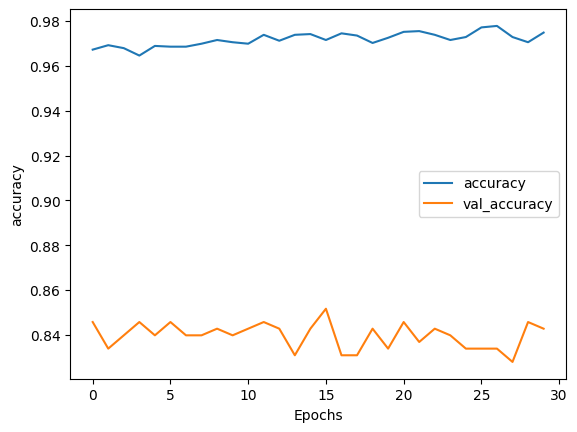

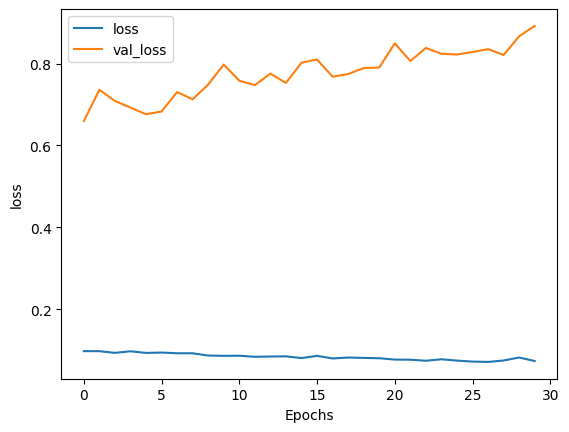

In [30]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history_1, "accuracy")
plot_graphs(history_1, "loss")

In [31]:
seed_text = "anjing liar"
# Convert the text into sequences
token_list = tokenizer.texts_to_sequences([seed_text])[0]
# Pad the sequences
token_list = pad_sequences([token_list], maxlen=MAXLEN , padding='pre')
# Get the probabilities of predicting a word
predicted = model.predict(token_list, verbose=0)
print("[HS             ,      non-HS]")
print(predicted)

[HS             ,      non-HS]
[[0.94675416 0.05324586]]


In [63]:
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length = MAXLEN),
    tf.keras.layers.Bidirectional(LSTM(16, return_sequences= True)),
    tf.keras.layers.Bidirectional(LSTM(32, return_sequences= True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(units = 32, activation= 'relu'),
    tf.keras.layers.Dense(units = 2, activation='softmax')
])
model_LSTM.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam() ,metrics=['accuracy'])

history_LSTM = model_LSTM.fit(train_padded_seq, train_labels_one_hot, epochs=30, validation_data=(val_padded_seq, test_labels_one_hot))

Epoch 1/30
95/95 [==============================] - 10s 62ms/step - loss: 0.6930 - accuracy: 0.5053 - val_loss: 0.6950 - val_accuracy: 0.4748
Epoch 2/30
95/95 [==============================] - 6s 58ms/step - loss: 0.6629 - accuracy: 0.5813 - val_loss: 0.4928 - val_accuracy: 0.7774
Epoch 3/30
95/95 [==============================] - 4s 45ms/step - loss: 0.3779 - accuracy: 0.8403 - val_loss: 0.5137 - val_accuracy: 0.7418
Epoch 4/30
95/95 [==============================] - 6s 65ms/step - loss: 0.3623 - accuracy: 0.8347 - val_loss: 0.4865 - val_accuracy: 0.8131
Epoch 5/30
95/95 [==============================] - 6s 63ms/step - loss: 0.3701 - accuracy: 0.8261 - val_loss: 0.4356 - val_accuracy: 0.7953
Epoch 6/30
95/95 [==============================] - 4s 43ms/step - loss: 0.3462 - accuracy: 0.8757 - val_loss: 0.4420 - val_accuracy: 0.8427
Epoch 7/30
95/95 [==============================] - 4s 46ms/step - loss: 0.3271 - accuracy: 0.8856 - val_loss: 0.4750 - val_accuracy: 0.8338
Epoch 8/30
9

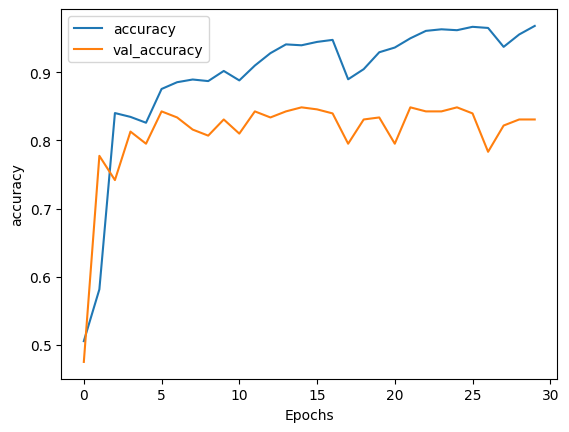

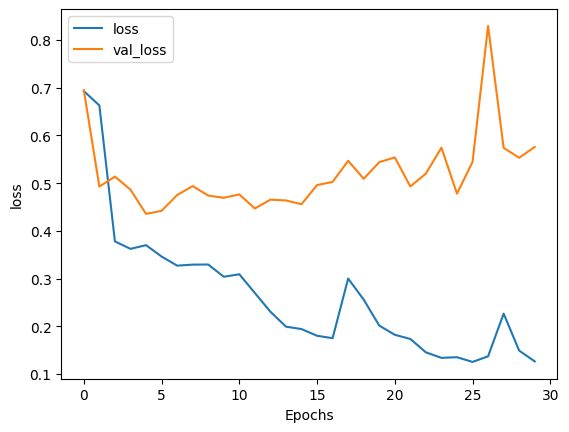

In [64]:
plot_graphs(history_LSTM, "accuracy")
plot_graphs(history_LSTM, "loss")

In [76]:
seed_text = "muka lu kayak anjing"
# Convert the text into sequences
token_list = tokenizer.texts_to_sequences([seed_text])[0]
# Pad the sequences
token_list = pad_sequences([token_list], maxlen=MAXLEN , padding='pre')
# Get the probabilities of predicting a word
predicted = model_LSTM.predict(token_list, verbose=0)
print("[HS             ,      non-HS]")
print(predicted)

[HS             ,      non-HS]
[[0.99097717 0.00902285]]
